In [886]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [887]:
print(tf.__version__)

2.12.0


In [888]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('mean_squared_error') < -100: #TODO:find target threshold
            print("\nReached desired accuracy so cancelling training")
            self.model.stop_training = True

callbacks = myCallback()

In [889]:
df = "../BiomassPredictonAI/final_harvest_data.csv"
dataset = pd.read_csv(df)
dataset.tail()

,date,index,plant_id,tray_id,row,column,LFW_g,LDW_g,LA_mm2,length_mm,...,plant_solidity,plant_perimeter,plant_width,plant_height,plant_longest_path,plant_convex_hull_vertices,plant_ellipse_major_axis,plant_ellipse_minor_axis,plant_ellipse_angle,plant_ellipse_eccentricity
160,23/02/2023,77,46,3,5,2,57.96,3.01,726.46,18.5,...,0.830678,767.938160,193,167,1367,33,190.580887,137.733093,62.138748,0.691160
161,23/02/2023,78,48,3,5,4,81.46,3.88,1001.79,21.0,...,0.852318,661.612260,164,189,1317,29,176.040924,141.141724,22.056726,0.597653
162,23/02/2023,79,50,3,5,6,140.84,6.38,1707.14,23.0,...,0.897274,683.754395,186,194,1427,31,191.379974,164.496170,175.959305,0.511091
163,23/02/2023,80,52,3,5,8,108.17,5.25,1364.18,31.4,...,0.913488,671.754395,198,179,1364,31,194.815384,159.870819,122.656914,0.571464
164,23/02/2023,81,54,3,5,10,64.40,3.35,812.24,21.0,...,0.809779,821.595015,189,168,1376,22,193.579941,133.306320,123.732269,0.725106


In [890]:
#TODO: feature engineering
def drop_axis(keyword):
    return dataset.drop(keyword, axis=1)

dataset = drop_axis("date")
dataset = drop_axis("index")
dataset = drop_axis("plant_id")
dataset = drop_axis("tray_id")
dataset = drop_axis("row")
dataset = drop_axis("column")
dataset = drop_axis("LFW_g")
dataset = drop_axis("LDW_g")
dataset = drop_axis("LA_mm2")
dataset = drop_axis("width_mm")
dataset = drop_axis("length_mm")
dataset.tail()


,height_mm,plant_area,plant_convex_hull_area,plant_solidity,plant_perimeter,plant_width,plant_height,plant_longest_path,plant_convex_hull_vertices,plant_ellipse_major_axis,plant_ellipse_minor_axis,plant_ellipse_angle,plant_ellipse_eccentricity
160,13.0,19084,22974.0,0.830678,767.938160,193,167,1367,33,190.580887,137.733093,62.138748,0.691160
161,14.8,18373,21556.5,0.852318,661.612260,164,189,1317,29,176.040924,141.141724,22.056726,0.597653
162,16.9,23374,26050.0,0.897274,683.754395,186,194,1427,31,191.379974,164.496170,175.959305,0.511091
163,16.6,23457,25678.5,0.913488,671.754395,198,179,1364,31,194.815384,159.870819,122.656914,0.571464
164,14.7,18533,22886.5,0.809779,821.595015,189,168,1376,22,193.579941,133.306320,123.732269,0.725106


In [891]:
dataset.describe().transpose()[['mean', 'std']]

,mean,std
height_mm,12.322424,4.501536
plant_area,14338.569697,12415.053296
plant_convex_hull_area,16600.530303,14801.909088
plant_solidity,0.855192,0.059827
plant_perimeter,570.369749,326.288761
plant_width,143.115152,72.628306
plant_height,129.575758,65.897292
plant_longest_path,1041.090909,537.448385
plant_convex_hull_vertices,27.418182,6.922104
plant_ellipse_major_axis,142.149979,74.902063


In [892]:
X = np.array(dataset)
X

array([[5.80000000e+00, 1.21100000e+03, 1.45600000e+03, ...,
        4.09659882e+01, 9.28785095e+01, 4.42607656e-01],
       [5.50000000e+00, 1.41200000e+03, 1.55650000e+03, ...,
        3.74846725e+01, 9.62554245e+01, 7.11801969e-01],
       [8.90000000e+00, 1.30300000e+03, 1.76650000e+03, ...,
        4.30591736e+01, 2.10217595e+00, 3.70421308e-01],
       ...,
       [1.69000000e+01, 2.33740000e+04, 2.60500000e+04, ...,
        1.64496170e+02, 1.75959305e+02, 5.11091089e-01],
       [1.66000000e+01, 2.34570000e+04, 2.56785000e+04, ...,
        1.59870819e+02, 1.22656914e+02, 5.71463790e-01],
       [1.47000000e+01, 1.85330000e+04, 2.28865000e+04, ...,
        1.33306320e+02, 1.23732269e+02, 7.25106204e-01]])

In [893]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(X)
print(normalizer.mean.numpy())

[[1.2322424e+01 1.4338570e+04 1.6600531e+04 8.5519230e-01 5.7036981e+02
  1.4311516e+02 1.2957578e+02 1.0410909e+03 2.7418180e+01 1.4214999e+02
  1.1166587e+02 9.1036919e+01 5.9000260e-01]]


In [894]:
y = pd.read_csv(df)
y = (y['LFW_g'])
y.tail()
y.to_numpy()

array([  1.3 ,   2.1 ,   3.36,   3.07,   3.17,   1.82,   3.12,   1.38,
         2.03,   2.15,   3.54,   2.02,   1.19,   3.66,   1.47,   2.46,
         1.79,   2.23,   2.54,   3.7 ,   3.  ,   2.14,   3.3 ,   2.29,
         2.44,   3.23,   2.64,   3.46,   2.91,   3.34,   2.51,   2.58,
         3.69,  10.95,   9.7 ,   9.2 ,  15.06,  12.86,  15.27,  11.26,
        15.29,  12.11,  14.64,   6.3 ,  11.32,   8.74,   9.59,   3.95,
         1.82,   8.66,  12.3 ,  12.4 ,  10.47,   8.98,   9.6 ,  13.69,
        14.39,  13.44,  13.76,  13.33,   6.82,  12.42,   6.76,  10.29,
         5.54,  16.44,   9.46,  12.24,   8.75,  15.56,  18.81,   9.89,
        19.94,  11.04,   9.87,   9.98,   4.92,   5.49,   6.23,   7.21,
         6.5 ,   6.22,   3.27,   7.94,  75.17, 137.06, 132.66, 140.07,
       134.19, 107.92, 160.7 , 129.16, 176.79, 147.64, 134.12, 103.44,
        99.95, 105.17, 100.88, 127.07, 107.53, 106.28, 110.52, 107.43,
        88.11, 136.21,  65.15,  96.16,  87.82, 108.08,  68.2 , 133.8 ,
      

In [895]:
def create_model():
    model = keras.Sequential([
        normalizer,
        #tf.keras.layers.Dense(16, activation="linear"),
        #tf.keras.layers.Dense(64, activation='relu'),
        #tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    model.compile(
        loss='mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.1)
    )

    return model

In [896]:
with np.printoptions(precision=2, suppress=True):
    print('First example:', X)
    print()
    print('Normalized:', normalizer(X).numpy())

First example: [[    5.8   1211.    1456.   ...    40.97    92.88     0.44]
 [    5.5   1412.    1556.5  ...    37.48    96.26     0.71]
 [    8.9   1303.    1766.5  ...    43.06     2.1      0.37]
 ...
 [   16.9  23374.   26050.   ...   164.5    175.96     0.51]
 [   16.6  23457.   25678.5  ...   159.87   122.66     0.57]
 [   14.7  18533.   22886.5  ...   133.31   123.73     0.73]]

Normalized: [[-1.45 -1.06 -1.03 ... -1.26  0.05 -0.97]
 [-1.52 -1.04 -1.02 ... -1.32  0.13  0.8 ]
 [-0.76 -1.05 -1.01 ... -1.23 -2.2  -1.44]
 ...
 [ 1.02  0.73  0.64 ...  0.94  2.1  -0.52]
 [ 0.95  0.74  0.62 ...  0.86  0.78 -0.12]
 [ 0.53  0.34  0.43 ...  0.39  0.81  0.89]]


In [897]:
model = create_model()
model.summary()

Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_70 (Normaliza  (None, 13)               27        
 tion)                                                           
                                                                 
 dense_103 (Dense)           (None, 1)                 14        
                                                                 
Total params: 41
Trainable params: 14
Non-trainable params: 27
_________________________________________________________________


In [898]:
history = model.fit(
    X,
    y,
    epochs=500,
    validation_split=0.1,
)

Epoch 1/500
5/5 [==============================] - 2s 41ms/step - loss: 5763.9111 - val_loss: 13086.5068
Epoch 2/500
5/5 [==============================] - 0s 9ms/step - loss: 5297.5317 - val_loss: 12108.4072
Epoch 3/500
5/5 [==============================] - 0s 9ms/step - loss: 4876.7974 - val_loss: 11189.3350
Epoch 4/500
5/5 [==============================] - 0s 10ms/step - loss: 4508.6997 - val_loss: 10335.9609
Epoch 5/500
5/5 [==============================] - 0s 10ms/step - loss: 4184.2334 - val_loss: 9560.5605
Epoch 6/500
5/5 [==============================] - 0s 10ms/step - loss: 3917.9929 - val_loss: 8859.0664
Epoch 7/500
5/5 [==============================] - 0s 10ms/step - loss: 3716.2632 - val_loss: 8217.7969
Epoch 8/500
5/5 [==============================] - 0s 9ms/step - loss: 3530.2695 - val_loss: 7665.5254
Epoch 9/500
5/5 [==============================] - 0s 9ms/step - loss: 3386.6353 - val_loss: 7184.6533
Epoch 10/500
5/5 [==============================] - 0s 9ms/step 

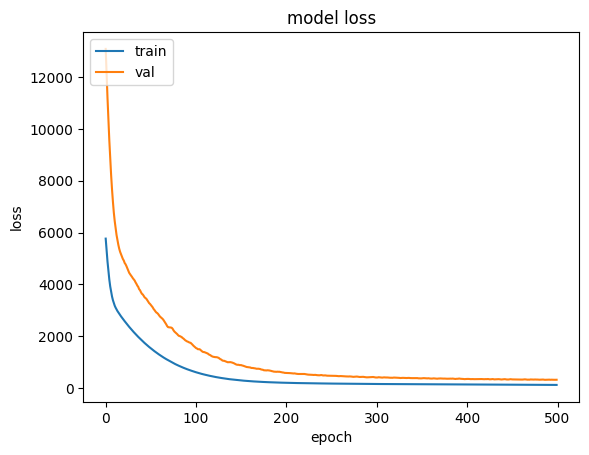

In [899]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show() 

In [900]:
history = pd.DataFrame(history.history)
history.tail()

,loss,val_loss
495,116.624352,313.835449
496,116.642738,313.572479
497,116.389519,314.092865
498,116.266167,315.439911
499,116.230217,315.406586
